In [1]:
from plot_lib import *
import pandas as pd 
from evaluation import *

DATA_DIR = 'recommender_outputs' 


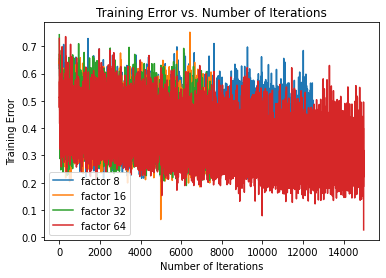

In [2]:
factor_arr = [8, 16, 32, 64]
error_dict = {}
for factor in factor_arr:
    df = pd.read_csv(f'{DATA_DIR}/math-german-no-features-{factor}_loss.csv')
    error_dict[f'factor {factor}'] = [df['loss_value'], df['iteration']]

iteration_error_plot(error_dict)

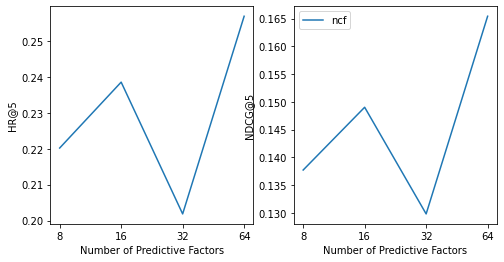

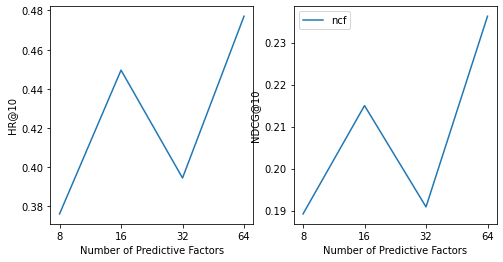

In [3]:

def create_plot_predictive_factor_eval(factor_arr, n):
    hr_dict, ndcg_dict = {'ncf': []}, {'ncf': []}
    for factor in factor_arr:
        hr, ndcg  = HitRate_NDCG(f'{DATA_DIR}/math-german-no-features-{factor}_probas.csv', n)
        hr_dict['ncf'].append(hr)
        ndcg_dict['ncf'].append(ndcg)
    predictive_factor_eval_plot(factor_arr, hr_dict, ndcg_dict, n)

create_plot_predictive_factor_eval(factor_arr = [8, 16, 32, 64], n=5)
create_plot_predictive_factor_eval(factor_arr = [8, 16, 32, 64], n=10)


In [ ]:
def create_plot_k_eval(k_arr, factor_arr):
    hr_dict, ndcg_dict = {}, {}
    for factor in factor_arr:
        hr_dict[f'factor {factor}'] = []
        ndcg_dict[f'factor {factor}'] = []
        for n in k_arr:
            hr, ndcg  = HitRate_NDCG(f'{DATA_DIR}/math-german-no-features-{factor}_probas.csv', n)
            hr_dict[f'factor {factor}'].append(hr)
            ndcg_dict[f'factor {factor}'].append(ndcg)
    k_eval_plot(k_arr, hr_dict, ndcg_dict)

create_plot_k_eval([5, 6, 7, 8, 9, 10], [8, 16, 32, 64])
